<a href="https://colab.research.google.com/github/NajouaMardi/sentiment-analysis/blob/master/app/Chi2%20with%20SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import joblib



In [11]:
#connecting to kaggle
'''!pip install -q kaggle
from google.colab import files
files.upload()  # upload kaggle.json from your Kaggle API account
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Replace 'username/dataset-name' with your actual path
!kaggle datasets download -d najouamardi/sample_labeled_sentiment
!unzip sample_labeled_sentiment.zip

SyntaxError: incomplete input (<ipython-input-11-6fe22dc29b99>, line 2)

In [24]:
#df = pd.read_csv('sample_labeled_sentiment.csv')
df_clean = pd.read_csv('processed_reviews_100k_cleaned.csv')
df_clean.head()


,rating,title,text,timestamp,helpful_vote,verified_purchase,label,full_text,sentiment,label_match
0,1.0,malware,mcaffee IS malware,1562182632076,0,0,negative,malware mcaffee is malware,negative,True
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,1424120336000,0,1,positive,lots of fun i love playing tapped out because ...,positive,True
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,1362399267000,0,1,positive,light up the dark i love this flashlight app i...,positive,True
3,4.0,Fun game,One of my favorite games,1561061428662,0,1,positive,fun game one of my favorite games,positive,True
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,1418257196000,0,1,positive,i am not that good at it but my kids are cute ...,positive,True


In [21]:
print("shape ",df.shape)
print("checking if data is missing",df.isnull().sum())
print("data types of columns",df.dtypes)

NameError: name 'df' is not defined

In [ ]:
#to drop empty lines with empty text or title
df_clean = df.dropna(subset=['title', 'text'])

In [25]:
print("shape after cleaning ",df_clean.shape)
print("checking if data is missing now",df_clean.isnull().sum())

shape after cleaning  (99708, 10)
checking if data is missing now rating               0
title                0
text                 0
timestamp            0
helpful_vote         0
verified_purchase    0
label                0
full_text            0
sentiment            0
label_match          0
dtype: int64


In [26]:
#Summary statistics for numeric columns
df_clean.describe()

,rating,timestamp,helpful_vote,verified_purchase
count,99708.000000,9.970800e+04,99708.000000,99708.000000
mean,3.819914,1.487554e+12,3.697798,0.947065
std,1.491207,9.132823e+10,19.713274,0.223904
min,1.000000,9.517750e+11,0.000000,0.000000
25%,3.000000,1.423705e+12,0.000000,1.000000
50%,5.000000,1.482899e+12,0.000000,1.000000
75%,5.000000,1.560087e+12,2.000000,1.000000
max,5.000000,1.679170e+12,2091.000000,1.000000


In [27]:
# Check the value counts of relevant categorical columns (e.g., "rating", "helpfulness")
df_clean['rating'].value_counts()

,count
rating,
5.0,51385
4.0,15758
1.0,15337
3.0,11126
2.0,6102


In [28]:
rating_counts = df_clean["rating"].value_counts().sort_index()
rating_percentages = (rating_counts / rating_counts.sum()) * 100

# Display nicely
rating_distribution = pd.DataFrame({
    "count": rating_counts,
    "percentage": rating_percentages.round(2)
})

print(rating_distribution)

        count  percentage
rating                   
1.0     15337       15.38
2.0      6102        6.12
3.0     11126       11.16
4.0     15758       15.80
5.0     51385       51.54


<Axes: title={'center': 'Distribution of Ratings'}, xlabel='rating'>

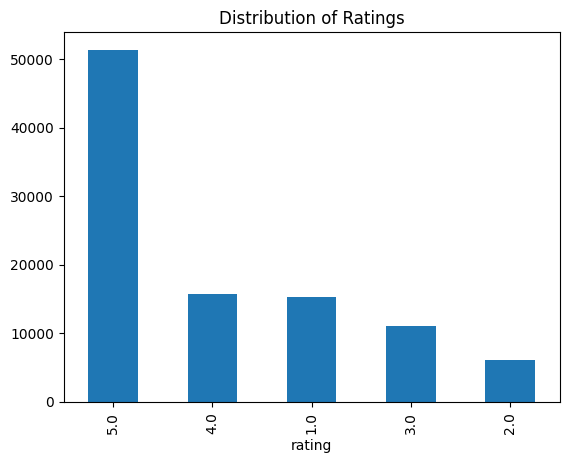

In [29]:
# If the dataset has a rating column or sentiment labels, explore their distribution
df_clean['rating'].value_counts().plot(kind='bar', title='Distribution of Ratings')

In [30]:
sentiment_counts = df_clean["sentiment"].value_counts()
sentiment_percentages = (sentiment_counts / len(df)) * 100
sentiment_summary = pd.DataFrame({
    "count": sentiment_counts,
    "percentage": sentiment_percentages.round(2)
})
print(sentiment_summary)

NameError: name 'df' is not defined

In [31]:
###Text preprocessing (applied on full_text (title and text)):
 ##Lowercase the text
 ##Remove punctuation and non-alphabetic characters
 ##Remove stop words

In [32]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#stemmer = PorterStemmer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stop words
    tokens = [word for word in text.split() if word not in stop_words]
    # Stemming
    #stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply to full_text (title+text)
df_clean['clean_full_text'] = df_clean['full_text'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [33]:
df_clean[:50]

,rating,title,text,timestamp,helpful_vote,verified_purchase,label,full_text,sentiment,label_match,clean_full_text
0,1.0,malware,mcaffee IS malware,1562182632076,0,0,negative,malware mcaffee is malware,negative,True,malware mcaffee malware
1,5.0,Lots of Fun,I love playing tapped out because it is fun to...,1424120336000,0,1,positive,lots of fun i love playing tapped out because ...,positive,True,lots fun love playing tapped fun watch town gr...
2,5.0,Light Up The Dark,I love this flashlight app! It really illumin...,1362399267000,0,1,positive,light up the dark i love this flashlight app i...,positive,True,light dark love flashlight app really illumina...
3,4.0,Fun game,One of my favorite games,1561061428662,0,1,positive,fun game one of my favorite games,positive,True,fun game one favorite games
4,4.0,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,1418257196000,0,1,positive,i am not that good at it but my kids are cute ...,positive,True,good kids cute game good kids love nik wallenda
5,4.0,good game,"Made me think , variety of the puzzles kept it...",1374994387000,0,1,positive,good game made me think variety of the puzzles...,positive,True,good game made think variety puzzles kept fun ...
6,5.0,My favorite showVoice my favorite show,See the voice anytime my My favorite show,1520456160247,0,1,positive,my favorite showvoice my favorite show see the...,positive,True,favorite showvoice favorite show see voice any...
7,5.0,Great Antivirus product,Not sure what else can be said about Norton pr...,1384358113000,0,0,positive,great antivirus product not sure what else can...,positive,True,great antivirus product sure else said norton ...
8,1.0,Fraught with too many problems,Save your money and purchase a good (i.e. Nort...,1366378695000,0,0,negative,fraught with too many problems save your money...,negative,True,fraught many problems save money purchase good...
9,4.0,Norton Internet Security,I always use Norton as my PC security applicat...,1365671303000,0,0,positive,norton internet security i always use norton a...,positive,True,norton internet security always use norton pc ...


In [34]:
X = df_clean['clean_full_text']
y = df_clean['sentiment']

In [35]:
# Split your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#f1_scorer = make_scorer(f1_score, average='weighted')

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('chi2', SelectKBest(score_func=chi2)),    ###Chi-Squared Test (chi²): A statistical test that can be used to evaluate the importance of each feature for classification.
    ('clf', LinearSVC(class_weight='balanced'))    #('clf', LinearSVC(class_weight='balanced'))
])

# Hyperparameters to tune
param_grid = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'chi2__k': [2000, 3000],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__max_iter': [1000, 3000]
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Grid search
#grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring=f1_scorer, n_jobs=-1)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

#Predictions on test set
y_pred = grid.predict(X_test)

# Print best parameters (based on F1)
print("Best max_features (TF-IDF):", grid.best_params_['tfidf__max_features'])
print("Best ngram_range (TF-IDF):", grid.best_params_['tfidf__ngram_range'])
print("Best k (SelectKBest):", grid.best_params_['chi2__k'])
print("Best C (LinearSVC):", grid.best_params_['clf__C'])
print("Best parameters (accuracy):", grid.best_score_)

# Show both F1 and Accuracy on the test set
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))  #if classes are balanced
print("Test F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted')) #if classes are imbalanced
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))  # Shows precision, recall, F1 per class

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# Save the best model
joblib.dump(grid.best_estimator_, 'best_svm_pipeline.pkl')



Best max_features (TF-IDF): 4000
Best ngram_range (TF-IDF): (1, 2)
Best k (SelectKBest): 3000
Best C (LinearSVC): 0.1
Best parameters (accuracy): 0.87375571658759
Test Accuracy: 0.8702236485808845
Test F1 Score (macro): 0.8014915654818567
Test F1 Score (weighted): 0.8685765863555215

Classification Report:

              precision    recall  f1-score   support

    negative       0.79      0.87      0.83      4569
     neutral       0.72      0.60      0.65      2562
    positive       0.93      0.92      0.93     12811

    accuracy                           0.87     19942
   macro avg       0.81      0.80      0.80     19942
weighted avg       0.87      0.87      0.87     19942

Confusion Matrix:
 [[ 3974   243   352]
 [  487  1533   542]
 [  596   368 11847]]


['best_svm_pipeline.pkl']

<pre>
SVM / CHI-2 SUR 100k

Best max_features (TF-IDF): 4000
Best ngram_range (TF-IDF): (1, 2)
Best k (SelectKBest): 3000
Best C (LinearSVC): 0.1
Best parameters (accuracy): 0.87375571658759
Test Accuracy: 0.8702236485808845
Test F1 Score (macro): 0.8014915654818567
Test F1 Score (weighted): 0.8685765863555215

Classification Report:

              precision    recall  f1-score   support

    negative       0.79      0.87      0.83      4569
     neutral       0.72      0.60      0.65      2562
    positive       0.93      0.92      0.93     12811

    accuracy                           0.87     19942
   macro avg       0.81      0.80      0.80     19942
weighted avg       0.87      0.87      0.87     19942

Confusion Matrix:
 [[ 3974   243   352]
 [  487  1533   542]
 [  596   368 11847]]

 </pre>

<pre>
Analysis:
✅ Positive reviews: Excellent performance with F1 = 0.93

✅ Negative reviews: Very good performance with F1 = 0.83

⚠️ Neutral reviews: Still your weakest class with F1 = 0.65

This is common in sentiment analysis — neutral sentiments are less clearly defined and can be semantically similar to both negative and positive.

Should You Try to Improve It?
If you really want to push performance further, here are some ideas:

🧪 Advanced Feature Ideas:
Add POS tags or syntactic features for neutral class (e.g., usage of modal verbs like “might”, “could”)

Try word embeddings (e.g., word2vec, GloVe, or FastText) if you're ready to go beyond TF-IDF

🤖 Alternative Models:
Try Logistic Regression or XGBoost for potentially more calibrated probabilities

Or fine-tune a pretrained Transformer (like BERT or DistilBERT) if your setup can handle it — this can dramatically boost performance, especially for complex classes like neutral.

</pre>